### Домашнее задание по теме «Рекомендации на основе содержания»


### Задание
- Использовать dataset MovieLens
- Построить рекомендации (регрессия, предсказываем оценку) на фичах:
- TF-IDF на тегах и жанрах
- Средние оценки (+ median, variance, etc.) пользователя и фильма
- Оценить RMSE на тестовой выборке

In [295]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [296]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [297]:
links = pd.read_csv('ml-latest-small/links.csv')
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [298]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [299]:
movies.shape

(9742, 3)

In [300]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [301]:
ratings.shape

(100836, 4)

In [302]:
tags = pd.read_csv('ml-latest-small/tags.csv')
tags.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [303]:
tags.shape

(3683, 4)

#### Вычислим среднюю оценку для каждого фильма:

In [304]:
avg_ratings = ratings[['movieId', 'rating']].copy()

In [305]:
avg_ratings = avg_ratings.groupby(['movieId'], as_index = False)['rating'].mean()

In [306]:
avg_ratings.head()

,movieId,rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


#### Преобразуем данные о жанрах в строки

In [308]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [309]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [310]:
movies['genres'] = [change_string(g) for g in movies.genres.values]

In [311]:
movies['genres'][:5]

0    Adventure Animation Children Comedy Fantasy
1                     Adventure Children Fantasy
2                                 Comedy Romance
3                           Comedy Drama Romance
4                                         Comedy
Name: genres, dtype: object

#### Добавим к данным о жанрах информацию о тегах

In [312]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [313]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [314]:
movies_with_tags = movies.join(tags.set_index('movieId'), on='movieId')
movies_with_tags.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09
1,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy,1.528844e+09
1,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game,1.528844e+09


#### Добавим оценку:

In [315]:
movies_with_tags = movies_with_tags.join(avg_ratings.set_index('movieId'), on='movieId')
movies_with_tags.head()

,movieId,title,genres,userId,tag,timestamp,rating
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09,3.920930
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09,3.920930
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09,3.920930
1,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy,1.528844e+09,3.431818
1,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game,1.528844e+09,3.431818


In [316]:
movies_with_tags.shape

(11853, 7)

#### Объединим теги и жанры

In [317]:
movies_with_tags[movies_with_tags.title == 'Toy Story (1995)']

,movieId,title,genres,userId,tag,timestamp,rating
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09,3.92093
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09,3.92093
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09,3.92093


In [318]:
movies_with_tags = movies_with_tags.dropna()

In [319]:
movies_with_tags_unique = movies_with_tags.copy()

In [320]:
movies_with_tags_unique['all_tags'] = movies_with_tags_unique['title'].apply(lambda x: (' ').join(list(movies_with_tags_unique[movies_with_tags_unique['title'] == x]['tag'].unique()))) 

In [321]:
movies_with_tags_unique['all_tags'] = movies_with_tags_unique['genres'] + ' ' + movies_with_tags_unique['all_tags'] 

In [322]:
movies_with_tags_unique.head()

,movieId,title,genres,userId,tag,timestamp,rating,all_tags
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09,3.920930,Adventure Animation Children Comedy Fantasy pi...
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09,3.920930,Adventure Animation Children Comedy Fantasy pi...
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09,3.920930,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy,1.528844e+09,3.431818,Adventure Children Fantasy fantasy magic board...
1,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game,1.528844e+09,3.431818,Adventure Children Fantasy fantasy magic board...


In [323]:
movies_reduced = movies_with_tags_unique.filter(['movieId', 'title','rating','all_tags'],axis = 1)

#### Удалим теги-дубликаты и отсутствующие значения

In [324]:
movies_reduced = movies_reduced.drop_duplicates()
movies_reduced = movies_reduced.dropna()
movies_reduced.head()

,movieId,title,rating,all_tags
0,1,Toy Story (1995),3.920930,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),3.431818,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),3.259615,Comedy Romance moldy old
4,5,Father of the Bride Part II (1995),3.071429,Comedy pregnancy remake
6,7,Sabrina (1995),3.185185,Comedy Romance remake


In [325]:
# Общее количество фильмов
movies_reduced.title.unique().shape

(1554,)

#### Преобразуем данные тегов и векторизуем их

In [326]:
def change_string(s):
    return str(s).replace('-', '').lower()

tag_strings = []
movies = []
ratings = []

for movie, group in tqdm_notebook(movies_reduced.groupby(['title','rating'])):
    tag_strings.append(' '.join([change_string(s) for s in group.all_tags.values]))
    movies.append(group.title.values[0])
    ratings.append(group.rating.values[0])

/home/polina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1554 [00:00<?, ?it/s]

In [327]:
tag_strings[:10]

['comedy drama romance artistic funny humorous inspiring intelligent quirky romance zooey deschanel',
 'drama thriller lawyers',
 'thriller creepy suspense',
 'comedy romance shakespeare sort of',
 'adventure children comedy dogs remake',
 'adventure animation children disney',
 'drama terrorism',
 'drama court claustrophobic confrontational earnest good dialogue great screenplay gritty motivational thoughtprovoking',
 'adventure drama thriller stranded',
 'comedy fantasy romance mark ruffalo']

In [328]:
len(tag_strings)

1554

In [329]:
movies[:5]

['(500) Days of Summer (2009)',
 '...And Justice for All (1979)',
 '10 Cloverfield Lane (2016)',
 '10 Things I Hate About You (1999)',
 '101 Dalmatians (1996)']

In [330]:
len(movies)

1554

In [331]:
ratings[:5]

[3.6666666666666665,
 3.1666666666666665,
 3.6785714285714284,
 3.5277777777777777,
 3.074468085106383]

In [332]:
len(ratings)

1554

In [480]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
#tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(tag_strings)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray())
print(tfidf_df.shape)

(1554, 1680)


In [481]:
tfidf_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679
count,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,...,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000
mean,0.000585,0.000573,0.001045,0.001000,0.000352,0.001355,0.001003,0.000035,0.000366,0.001405,...,0.000267,0.000281,0.003421,0.000427,0.000286,0.000296,0.000317,0.000825,0.002492,0.000253
std,0.013598,0.022596,0.029486,0.027858,0.013878,0.032179,0.028345,0.001373,0.014416,0.018488,...,0.010519,0.011084,0.044582,0.016821,0.011257,0.011679,0.012497,0.023006,0.043923,0.009962
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.389609,0.890742,0.940590,0.786799,0.547077,0.975324,0.912031,0.054120,0.568288,0.325131,...,0.414667,0.436960,0.683894,0.663083,0.443755,0.460414,0.492627,0.662690,0.833245,0.392721


#### Подготовим тестовые и тренировочные данные

In [526]:
X = tfidf_df
y = ratings

In [527]:
X.shape

(1554, 1680)

In [484]:
i = 100

In [485]:
tag_strings[i]

'drama horror thriller atmospheric dark metaphorical psychological'

In [486]:
y[i]

4.5

<AxesSubplot:>

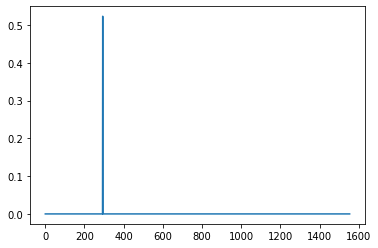

In [487]:
X[i].plot()

In [488]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [521]:
pca = PCA(n_components=0.3, whiten=True)

X = pca.fit_transform(X)

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Построим модель и предскажем рейтинг

In [529]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_jobs= -1,max_depth = 500, random_state = 0,max_features = 'log2')
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

In [530]:
# RMSE:
mean_squared_error(y_test, predictions)

0.23178529896127148

In [531]:
rf.score(X_test, y_test)

0.18328196426147303

In [532]:
y_test[:10]

[3.35,
 3.8,
 3.2083333333333335,
 3.2596153846153846,
 2.7291666666666665,
 3.8333333333333335,
 3.4838709677419355,
 3.5,
 3.5,
 4.277777777777778]

In [533]:
predictions[:10]

array([3.70034763, 3.81647809, 3.631394  , 3.4778201 , 2.55251199,
       3.75971708, 3.56147995, 3.55950675, 3.80140092, 3.87335596])